<a href="https://colab.research.google.com/github/Pretty-Witty-Bot/ReinforcementLearningModels/blob/main/TryhardBoxcartModelAttempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
"""
Install the necessary libraries and modules.
"""

!pip install gym
!pip install gym[classic_control]
!pip install torch
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
"""
Import the necessary libraries and modules.
"""

import gym
import matplotlib.pyplot as plt 
from gym.wrappers import RecordVideo

In [ ]:
"""
Initialize the environment and the video recorder.
"""

env = gym.make('MountainCar-v0', render_mode = 'rgb_array')
# Store videos in ./naive_video directory.
video_recorder = RecordVideo(env, './naive_video') 

In [119]:
"""
Figure out the dimensions that we are working with.
"""

obs_space = env.observation_space
action_space = env.action_space

print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space: Discrete(3)


In [98]:
"""
QNetwork Class. Derived from: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda
"""

import torch 
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size = 2, action_size = 3, seed = 0, fc1_unit=64,
                 fc2_unit = 48, fc3_unit = 24):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,fc3_unit)
        self.fc4 = nn.Linear(fc3_unit,action_size)
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        #print(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [99]:
"""
Agent Class. Derived from: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda
"""

import numpy as np
import random 
from collections import namedtuple, deque 

##Importing the model (function approximator for Q-table)

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-1              # for soft update of target parameters
LR = 1e-1               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns form environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        #print(action_values)

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_state, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = torch.nn.MSELoss()
        # Local model is one which we need to train so it's in training mode
        self.qnetwork_local.train()
        # Target model is one with which we need to get our target so it's in evaluation mode
        # So that when we do a forward pass with target model it does not calculate gradient.
        # We will update target model weights with soft_update function
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_state).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))
        
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [115]:
"""
Run the DQN Training Algorithm. Derived from: https://unnatsingh.medium.com/deep-q-network-with-pytorch-d1ca6f40bfda
"""

agent = Agent(state_size=2,action_size=3,seed=0)

def dqn(n_episodes= 200, max_t = 1000, eps_start=0.99):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    episode_scores = []
    scores = [] # list containing score from each episode
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,pre_reward,done,_ = env.step(action)
            reward = -(0.5 - next_state[0]) + pre_reward
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                break
            scores.append(score) ## sae the most recent score
        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode,np.mean(scores)))
        episode_scores.append(np.mean(scores))
    return scores, episode_scores

scores, episode_scores = dqn()

Episode 1	Average Score -201.51
Episode 2	Average Score -201.71
Episode 3	Average Score -201.96
Episode 4	Average Score -202.21
Episode 5	Average Score -202.24
Episode 6	Average Score -202.40
Episode 7	Average Score -202.31
Episode 8	Average Score -202.12
Episode 9	Average Score -202.16
Episode 10	Average Score -202.13
Episode 11	Average Score -202.18
Episode 12	Average Score -202.23
Episode 13	Average Score -202.27
Episode 14	Average Score -202.32
Episode 15	Average Score -202.18
Episode 16	Average Score -202.13
Episode 17	Average Score -202.20
Episode 18	Average Score -202.23
Episode 19	Average Score -202.18
Episode 20	Average Score -202.19
Episode 21	Average Score -202.23
Episode 22	Average Score -202.24
Episode 23	Average Score -202.29
Episode 24	Average Score -202.25
Episode 25	Average Score -202.28
Episode 26	Average Score -202.30
Episode 27	Average Score -202.31
Episode 28	Average Score -202.37
Episode 29	Average Score -202.40
Episode 30	Average Score -202.41
Episode 31	Average 

In [109]:
"""
Record the Agent picking only what it thinks is the best action.
"""

video_recorder = RecordVideo(env, './naive_video')

state = env.reset()
video_recorder.start_video_recorder()

STEPS = 1000
for _ in range(STEPS):  

  video_recorder.reset() # reset the environment and see the initial observation    

  # Sample a random action from the entire action space
  random_action = agent.act(state, eps = 1)

  # # Take the action and get the new observation space.
  new_obs, reward, done, info = env.step(random_action)

  video_recorder.render() # Renders and records the environment.


video_recorder.close_video_recorder()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/naive_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


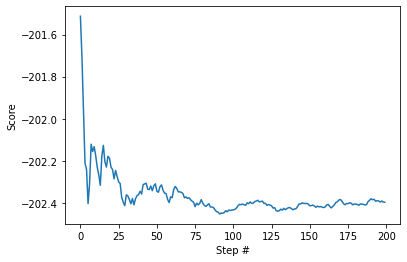

In [118]:
"""
Plotting the scores.
"""

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episode_scores)
plt.ylabel('Score')
plt.xlabel('Step #')
plt.show()

# The score decreased. Wow.